In [1]:
import pandas as pd
import numpy as np
import requests
from tqdm.auto import tqdm
from scipy.stats import mode 
from pprint import pprint
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender
import warnings
warnings.filterwarnings("ignore")
import dill
from rectools import Columns
from rectools.dataset import Dataset

from userknn import UserKnn

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 200)

# Get KION dataset 

<a href="https://ods.ai/competitions/competition-recsys-21/data"> Dataset description [ru] </a>


In [2]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [3]:
!unzip kion_train.zip

# EDA

In [4]:
interactions = pd.read_csv('kion_train/interactions.csv')
users = pd.read_csv('kion_train/users.csv')
items = pd.read_csv('kion_train/items.csv')

In [5]:
# rename columns, convert timestamp
interactions.rename(columns={'last_watch_dt': Columns.Datetime,
                            'total_dur': Columns.Weight}, 
                    inplace=True) 

interactions['datetime'] = pd.to_datetime(interactions['datetime'])

## interactions

In [6]:
pd.concat([interactions.head(), interactions.tail()])

,user_id,item_id,datetime,weight,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [7]:
print(f"Interactions dataframe shape: {interactions.shape}")
print(f"Unique users in interactions: {interactions['user_id'].nunique():_}")
print(f"Unique items in interactions: {interactions['item_id'].nunique():_}")

Interactions dataframe shape: (5476251, 5)
Unique users in interactions: 962_179
Unique items in interactions: 15_706


In [8]:
max_date = interactions['datetime'].max()
min_date = interactions['datetime'].min()

print(f"min date in interactions: {min_date}")
print(f"max date in interactions: {max_date}")

min date in interactions: 2021-03-13 00:00:00
max date in interactions: 2021-08-22 00:00:00


In [9]:
interactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5476251 entries, 0 to 5476250
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   user_id      int64         
 1   item_id      int64         
 2   datetime     datetime64[ns]
 3   weight       int64         
 4   watched_pct  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 208.9 MB


## users

In [10]:
pd.concat([users.head(), users.tail()])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
3,721985,age_45_54,income_20_40,Ж,0
4,704055,age_35_44,income_60_90,Ж,0
840192,339025,age_65_inf,income_0_20,Ж,0
840193,983617,age_18_24,income_20_40,Ж,1
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [11]:
print(f"Users dataframe shape {users.shape}")
print(f"Unique users: {users['user_id'].nunique():_}")

Users dataframe shape (840197, 5)
Unique users: 840_197


## items

In [13]:
pd.concat([items.head(2), items.tail(2)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Грандинетти, Джеральдин Чаплин, Елена Анайя, Каэтано Велозо, Леонор Уотлинг, Лола Дуэньяс, Лолес Леон, Малу Айродо, Мариола Фуэнтес, Пас Вега, Пина Бауш, Ро...",Мелодрама легендарного Педро Альмодовара «Поговори с ней» в 2003 году получила премию «Оскар» за лучший сценарий. Журналист Марко берет интервью у знаменитой женщины-тореро Лидии и вскоре влюбляе...,"Поговори, ней, 2002, Испания, друзья, любовь, сильные, женщины, преодоление, трудностей, отношения, дружба, отношения, паре, отношения, мужчины, женщины, романтические, отношения, потеря, близких,..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон Манцукас, Джон Глейсер, Карл Грин, Кристен Риттер, Лэнс Реддик, Морис Комт, Патрик Кернс, Ребекка Коллинз, Роза Салазар, Росс П. Кук, Стеффи Гроут, Ти...","Уморительная современная комедия на популярную тему о том, как не надо отмечать мальчишник. Главный герой усвоил, что не надо звать на свадьбу своего друга Джейсона, из-за которого он вместо сваде...","Голые, перцы, 2014, США, друзья, свадьбы, преодоление, трудностей, расставания, отношения, дружба, риск, недоразумение, мужская, дружба, мальчишники, девичники"
15961,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родди, Марк О’Халлоран, Джимми Смоллхорн","Семнадцатилетний Дэмиен мечтает вырваться за пределы своего района и стать профессиональным бойцом. Когда его кумир и старший брат исчезает, парень попадает в чуждый ему мир насилия, наркотиков и ...","Среди, камней, 2019, Россия"
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы не попасть в нелепую и курьёзную историю. Но даже неудачники мечтают о любви, и наш герой — не исключение, ведь оптимизма ему не занимать.","Гоша, 2019, Россия"


In [14]:
print(f"Items dataframe shape {items.shape}")
print(f"Unique item_id: {items['item_id'].nunique():_}")

Items dataframe shape (15963, 14)
Unique item_id: 15_963


#  userkNN model  CV

Compare implicit `CosineRecommender` and `TFIDFRecommender` as an ItemKnn base 



In [15]:
# setting for cv
# В другом ноутбуке делали проверку на разном количестве фолдов. Заметили, что больше 1 фолда делать смысла нет.
# Метрика MAP больше не становится. Поэтому возьмём количество фолдов равным 1.

n_folds = 1
unit = "W"
n_units = 1

last_date = interactions[Columns.Datetime].max().normalize()
start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  
print(f"Start date and last date of the test fold: {start_date, last_date}")

Start date and last date of the test fold: (Timestamp('2021-08-08 00:00:00'), Timestamp('2021-08-22 00:00:00'))


### Test fold borders

In [16]:
from rectools.model_selection import TimeRangeSplit

periods = n_folds + 1
freq = f"{n_units}{unit}"
print(
    f"start_date: {start_date}\n"
    f"last_date: {last_date}\n"
    f"periods: {periods}\n"
    f"freq: {freq}\n"
)
    
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

# generator of folds
cv = TimeRangeSplit(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)
print(f"Real number of folds: {cv.get_n_splits(interactions)}")

start_date: 2021-08-08 00:00:00
last_date: 2021-08-22 00:00:00
periods: 2
freq: 1W

Test fold borders: ['2021-08-08' '2021-08-15']
Real number of folds: 1


In [17]:
from rectools.metrics import MAP, calc_metrics

# calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "MAP": MAP(k=10)
}

models = {
    "BM25": BM25Recommender()
}

# Model training by fold

In [18]:
%%time

results = []

fold_iterator = cv.split(interactions, collect_fold_stats=True)

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    pprint(fold_info)

    df_train = interactions.iloc[train_ids].copy()
    df_test = interactions.iloc[test_ids][Columns.UserItem].copy()

    catalog = df_train[Columns.Item].unique()
    
    for model_name, model in models.items():
        userknn_model = UserKnn(model=model, N_users=50)
        userknn_model.fit(df_train)
    
        recos = userknn_model.predict(df_test)
    
        metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=df_test,
            prev_interactions=df_train,
            catalog=catalog
        )
    
        fold = {"fold": i_fold, "model": model_name}
        fold.update(metric_values)
        results.append(fold)
        


==================== Fold 0
{'End date': Timestamp('2021-08-15 00:00:00', freq='W-SUN'),
 'Start date': Timestamp('2021-08-08 00:00:00', freq='W-SUN'),
 'Test': 276699,
 'Test items': 6715,
 'Test users': 101983,
 'Train': 4587708,
 'Train items': 15404,
 'Train users': 842129}


  0%|          | 0/842129 [00:00<?, ?it/s]

CPU times: total: 3h 24min 47s
Wall time: 1h 21min 29s


In [19]:
# Сохраним нашу обученную модель чтобы потом её можно было использовать в сервисе "на лету".

with open('BM25.dill', 'wb') as f:
    dill.dump(models['BM25'], f)

# 👌 Metrics 

`Metrics by fold`



## Metric description 
- ### <a href="https://rectools.readthedocs.io/en/latest/api/rectools.metrics.novelty.MeanInvUserFreq.html#rectools.metrics.novelty.MeanInvUserFreq"> Mean Inverse User Frequency (novelty)</a>

- ### <a href="https://rectools.readthedocs.io/en/latest/api/rectools.metrics.serendipity.Serendipity.html"> Serendipity = novelty and relevance</a>

In [20]:
df_metrics = pd.DataFrame(results)
df_metrics

,fold,model,MAP
0,0,BM25,0.001478


In [21]:
df_metrics.to_pickle("df_metrics.pickle")

## Metrics mean by fold
`we can compare two models`

In [22]:
df_metrics.groupby('model').mean()[metrics.keys()]

,MAP
model,
BM25,0.001478


In [27]:
# Посмотрим работает ли модель.

models['BM25'].similar_items(0, N=11)[1:]

[(24915, 34.679276323449564),
 (185438, 28.62270521265893),
 (315048, 26.911215967290502),
 (40801, 25.957406400995612),
 (239465, 25.26819604160363),
 (414234, 23.839365020516475),
 (117987, 23.681248963396065),
 (407554, 23.379676332017773),
 (57319, 23.292233407467016),
 (329234, 23.24698549853704)]

In [ ]:
# Модель на лидерборде.

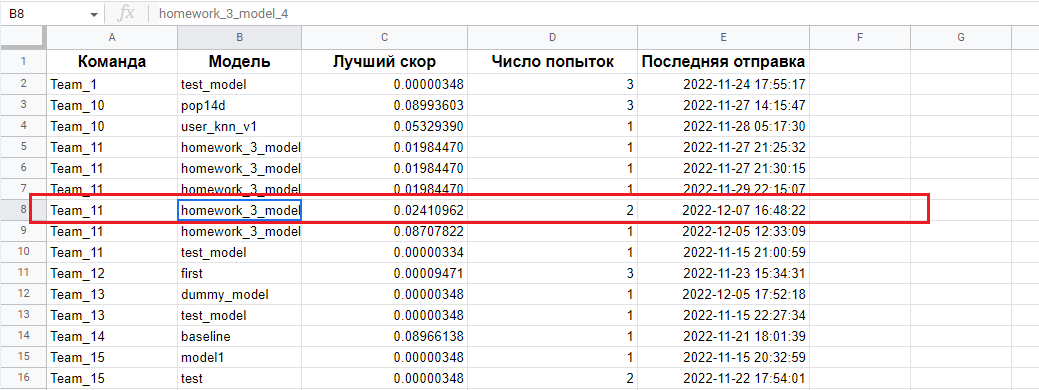